In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np

def logistic(x):
    """Sigmoid function to model swing probability"""
    return 1 / (1 + np.exp(-x))

def clean_presidential_data(file_path):
    """Reads and filters presidential election data."""
    df = pd.read_csv(file_path)  # Read the original Excel file

    # Filter rows for 'President of the US'
    presidential_df = df[df['Office Name'] == 'President of the US']

    # Keep necessary columns
    presidential_df = presidential_df[['Precinct', 'Ballot Name', 'Party', 'Total']]

    # Remove rows for 'Total Votes' and 'Ballots Cast'
    presidential_df = presidential_df[~presidential_df['Ballot Name'].isin(['Total Votes', 'Ballots Cast'])]

    return presidential_df

def calculate_swing_probabilities(df):
    """Calculates swing probabilities based on margin between top two candidates."""
    swing_probs = []

    # Group data by precinct
    for precinct, group in df.groupby('Precinct'):
        sorted_group = group.sort_values(by='Total', ascending=False)

        if len(sorted_group) < 2:
            continue  # Skip precincts with less than two candidates

        # Get top two candidates' votes
        top1, top2 = sorted_group.iloc[0]['Total'], sorted_group.iloc[1]['Total']
        total_votes = sorted_group['Total'].sum()

        # Compute margin percentage
        margin = abs(top1 - top2) / total_votes

        # Adjust swing probability calculation
        swing_prob = 1 - logistic((margin - 0.03) * 25)

        # Apply correction for third-party candidates
        if len(sorted_group) > 2:
            third_party_total = sorted_group.iloc[2:]['Total'].sum()
            third_party_factor = 1 - (third_party_total / total_votes)
            swing_prob *= third_party_factor  # Reduce swing probability if third-party candidates are strong

        swing_probs.append((precinct, swing_prob))

    return swing_probs

def main():
    file_path = "/content/drive/MyDrive/CSVs/Voter Data 2024.csv"  # Update this with the actual file path
    cleaned_data = clean_presidential_data(file_path)

    swing_probs = calculate_swing_probabilities(cleaned_data)

    # Print results
    print("Swing Probabilities by Precinct:")
    for precinct, prob in swing_probs:
        print(f"{precinct}: {prob:.2%}")

if __name__ == "__main__":
    main()


Swing Probabilities by Precinct:
001 Harbins A: 2.36%
002 Rockbridge A: 0.00%
003 Dacula: 3.16%
004 Suwanee A: 10.99%
005 Baycreek A: 6.73%
006 Goodwins A: 5.07%
007 Duluth A: 1.76%
008 Duncans A: 4.72%
009 Pucketts A: 0.88%
010 Cates A: 23.89%
011 Berkshire A: 0.31%
012 Berkshire B: 0.33%
013 Duncans C: 0.49%
014 Garners A: 29.61%
015 Lawrenceville A: 1.35%
016 Lawrenceville B: 0.05%
017 Martins A: 0.05%
018 Martins B: 0.36%
019 Martins C: 0.84%
020 Pinckneyville A: 0.00%
021 Pinckneyville B: 0.08%
022 Pinckneyville C: 6.41%
023 Pinckneyville D: 0.04%
024 Sugar Hill A: 19.30%
025 Sugar Hill B: 35.38%
026 Hog Mountain A: 1.68%
027 Hog Mountain B: 62.36%
028 Rockycreek A: 59.94%
029 Cates B: 57.50%
030 Cates C: 0.05%
031 Hog Mountain D: 38.23%
032 Berkshire D: 5.00%
033 Berkshire E: 47.49%
034 Berkshire F: 12.98%
035 Cates D: 1.66%
036 Cates E: 7.21%
037 Pinckneyville E: 0.00%
038 Pinckneyville F: 0.08%
039 Duncans D: 0.90%
040 Pinckneyville H: 3.16%
041 Baycreek B: 0.01%
042 Lawrencevi

In [ ]:
#Clean 2020 Dataset in a different manner

def clean_presidential_data_2020(file_path):
    """Reads and cleans the 2020 presidential election data."""
    df = pd.read_csv(file_path, header=[2])  # Load data using third row as headers

    # Print detected columns for debugging
    print("Detected Columns:", df.columns.tolist())

    # Manually map vote columns (based on their actual names)
    vote_columns = {
        "Total Votes": "Trump Votes",     # First "Total Votes" column (Trump)
        "Total Votes.1": "Biden Votes",   # Second "Total Votes" column (Biden)
        "Total Votes.2": "Jorgensen Votes" # Third "Total Votes" column (Jorgensen)
    }

    # Ensure all necessary columns exist before renaming
    missing_cols = [col for col in vote_columns.keys() if col not in df.columns]
    if missing_cols:
        raise KeyError(f"Missing expected vote columns: {missing_cols}")

    # Rename vote columns
    df = df.rename(columns=vote_columns)

    # Convert vote columns to numeric
    for new_col in vote_columns.values():
        df[new_col] = pd.to_numeric(df[new_col], errors='coerce')

    # Rename "County" to "Precinct"
    df = df.rename(columns={"County": "Precinct"})

    # Keep only relevant columns
    df = df[['Precinct', 'Trump Votes', 'Biden Votes', 'Jorgensen Votes']]

    # Drop NaN values and invalid precincts
    df = df.dropna()

    return df

def restructure_2020_to_match_2024(df):
    """Restructure 2020 data to match 2024 format."""
    reshaped_data = []

    for _, row in df.iterrows():
        reshaped_data.append({'Precinct': row['Precinct'], 'Ballot Name': 'Donald J. Trump', 'Party': 'Rep', 'Total': row['Trump Votes']})
        reshaped_data.append({'Precinct': row['Precinct'], 'Ballot Name': 'Joseph R. Biden', 'Party': 'Dem', 'Total': row['Biden Votes']})
        reshaped_data.append({'Precinct': row['Precinct'], 'Ballot Name': 'Jo Jorgensen', 'Party': 'Lib', 'Total': row['Jorgensen Votes']})

    return pd.DataFrame(reshaped_data)


In [ ]:
def compare_election_years(file_path_2020, file_path_2024):
    """Compares swing probabilities between two election years."""
    df_2020 = clean_presidential_data_2020(file_path_2020)
    df_2020 = restructure_2020_to_match_2024(df_2020)  # Reshape 2020 data

    df_2024 = clean_presidential_data(file_path_2024)  # 2024 already structured

    swing_2020 = dict(calculate_swing_probabilities(df_2020))
    swing_2024 = dict(calculate_swing_probabilities(df_2024))

    swing_diffs = {precinct: abs(swing_2024.get(precinct, 0) - swing_2020.get(precinct, 0))
                   for precinct in swing_2024.keys()}

    return swing_diffs

def print_swing_differences(file_path_2020, file_path_2024):
    """Prints the swing probability differences between 2020 and 2024."""
    swing_diffs = compare_election_years(file_path_2020, file_path_2024)

    print("Swing Probability Changes Between 2020 and 2024:")
    for precinct, diff in sorted(swing_diffs.items(), key=lambda x: x[1], reverse=True):
        print(f"{precinct}: {diff:.2%}")

# Example usage
file_path_2020 = "/content/drive/MyDrive/CSVs/Voter Data 2020.csv"
file_path_2024 = "/content/drive/MyDrive/CSVs/Voter Data 2024.csv"
print_swing_differences(file_path_2020, file_path_2024)


Detected Columns: ['County', 'Registered Voters', 'Election Day Votes', 'Advanced Voting Votes', 'Absentee by Mail Votes', 'Provisional Votes', 'Total Votes', 'Election Day Votes.1', 'Advanced Voting Votes.1', 'Absentee by Mail Votes.1', 'Provisional Votes.1', 'Total Votes.1', 'Election Day Votes.2', 'Advanced Voting Votes.2', 'Absentee by Mail Votes.2', 'Provisional Votes.2', 'Total Votes.2', 'Total']
Swing Probability Changes Between 2020 and 2024:
070 Goodwins B: 65.92%
137 Rockycreek B: 65.10%
027 Hog Mountain B: 62.36%
136 Hog Mountain C: 61.59%
028 Rockycreek A: 59.94%
089 Sugar Hill E: 58.22%
152 Rockycreek C: 58.18%
042 Lawrenceville C: 57.81%
029 Cates B: 57.50%
138 Duluth I: 55.26%
119 Berkshire O: 55.22%
107 Cates O: 53.78%
100 Suwanee B: 52.93%
092 Berkshire J: 48.51%
033 Berkshire E: 47.49%
085 Lawrenceville H: 47.19%
094 Cates N: 46.73%
096 Duluth G: 41.59%
142 Suwanee F: 41.57%
131 Suwanee E: 39.98%
031 Hog Mountain D: 38.23%
133 Harbins B: 37.63%
025 Sugar Hill B: 35.38

In [ ]:
!pip install geopandas matplotlib contextily


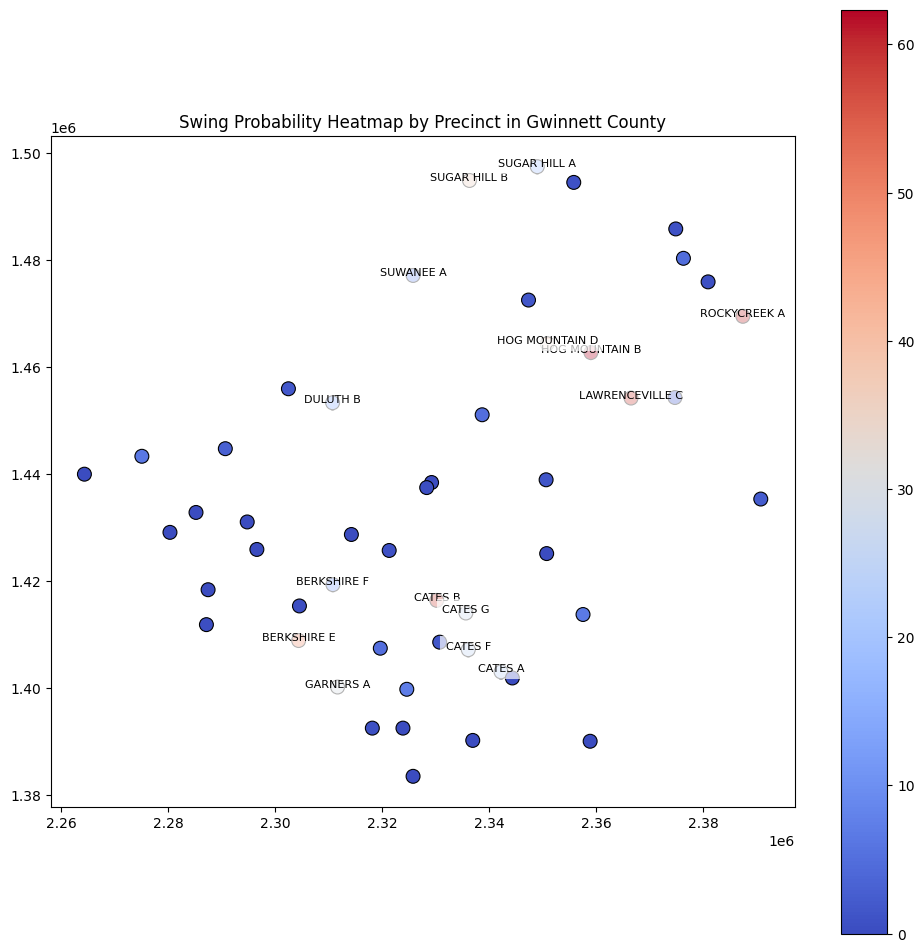

In [ ]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

# Path to your shapefile ZIP stored in Google Drive
shapefile_path = "/content/drive/MyDrive/CSVs/Administrative_-5726998422312426082.zip"

# Load the shapefile
gdf = gpd.read_file(shapefile_path)

# Swing probability data
swing_data = {
    "Precinct": [
        "Harbins A", "Rockbridge A", "Dacula", "Suwanee A", "Baycreek A",
        "Goodwins A", "Duluth A", "Duncans A", "Pucketts A", "Cates A",
        "Berkshire A", "Berkshire B", "Duncans C", "Garners A", "Lawrenceville A",
        "Lawrenceville B", "Martins A", "Martins B", "Martins C", "Pinckneyville A",
        "Pinckneyville B", "Pinckneyville C", "Pinckneyville D", "Sugar Hill A", "Sugar Hill B",
        "Hog Mountain A", "Hog Mountain B", "Rockycreek A", "Cates B", "Cates C",
        "Hog Mountain D", "Berkshire D", "Berkshire E", "Berkshire F", "Cates D",
        "Cates E", "Pinckneyville E", "Pinckneyville F", "Duncans D", "Pinckneyville H",
        "Baycreek B", "Lawrenceville C", "Martins D", "Rockbridge B", "Garners B",
        "Cates F", "Cates G", "Duluth B", "Garners C", "Pinckneyville I"
    ],
    "Swing Probability": [
        2.36, 0.00, 3.16, 10.99, 6.73, 5.07, 1.76, 4.72, 0.88, 23.89, 0.31, 0.33, 0.49, 29.61, 1.35,
        0.05, 0.05, 0.36, 0.84, 0.00, 0.08, 6.41, 0.04, 19.30, 35.38, 1.68, 62.36, 59.94, 57.50, 0.05,
        38.23, 5.00, 47.49, 12.98, 1.66, 7.21, 0.00, 0.08, 0.90, 3.16, 0.01, 57.81, 0.15, 0.00, 0.02,
        25.29, 27.32, 16.10, 0.57, 0.04
    ]
}


# Convert to DataFrame
df = pd.DataFrame(swing_data)

# Ensure the precinct column matches the format in the shapefile
df["Precinct"] = df["Precinct"].str.upper()  # Convert to uppercase if necessary
gdf["PRECINCT_N"] = gdf["PRECINCT_N"].str.upper()  # Convert shapefile column to uppercase

# Merge shapefile with swing probability data
gdf = gdf.merge(df, left_on="PRECINCT_N", right_on="Precinct", how="left")

# Filter top precincts with highest swing probabilities (top 10 by default)
top_precincts = gdf.nlargest(15, "Swing Probability")

# Create plot
fig, ax = plt.subplots(figsize=(12, 12))
gdf.plot(column="Swing Probability", cmap="coolwarm", linewidth=0.8, edgecolor='black', legend=True, ax=ax, markersize=100)  # Increased marker size

# Add labels only to the highest swing probability precincts
for x, y, label in zip(top_precincts.geometry.centroid.x, top_precincts.geometry.centroid.y, top_precincts["Precinct"]):
    plt.text(x, y, label, fontsize=8, ha="center", color="black", bbox=dict(facecolor="white", alpha=0.7, edgecolor="none"))

ax.set_title("Swing Probability Heatmap by Precinct in Gwinnett County")

# Show the plot
plt.show()

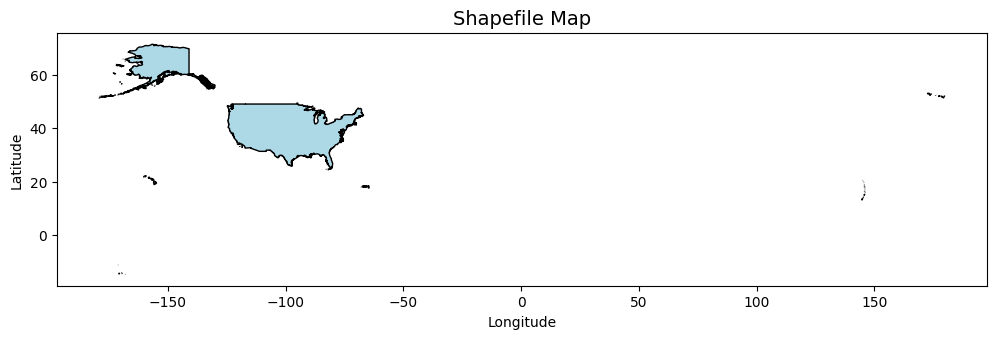

In [ ]:
import geopandas as gpd
import zipfile
import os
import matplotlib.pyplot as plt

# 📌 Step 1: Define Paths
zip_path = "/content/drive/MyDrive/CSVs/cb_2018_us_nation_5m.zip"
extract_path = "/content/drive/MyDrive/CSVs/shapefile_extracted"

# 📌 Step 2: Extract the ZIP file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# 📌 Step 3: Find the Shapefile Path
shapefile_path = [file for file in os.listdir(extract_path) if file.endswith(".shp")][0]
full_shapefile_path = os.path.join(extract_path, shapefile_path)

# 📌 Step 4: Load the Shapefile using GeoPandas
gdf = gpd.read_file(full_shapefile_path)

# 📌 Step 5: Plot the Shapefile
fig, ax = plt.subplots(figsize=(12, 8))
gdf.plot(ax=ax, edgecolor="black", facecolor="lightblue")

# 📌 Step 6: Customize the Plot
ax.set_title("Shapefile Map", fontsize=14)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

# Show the plot
plt.show()


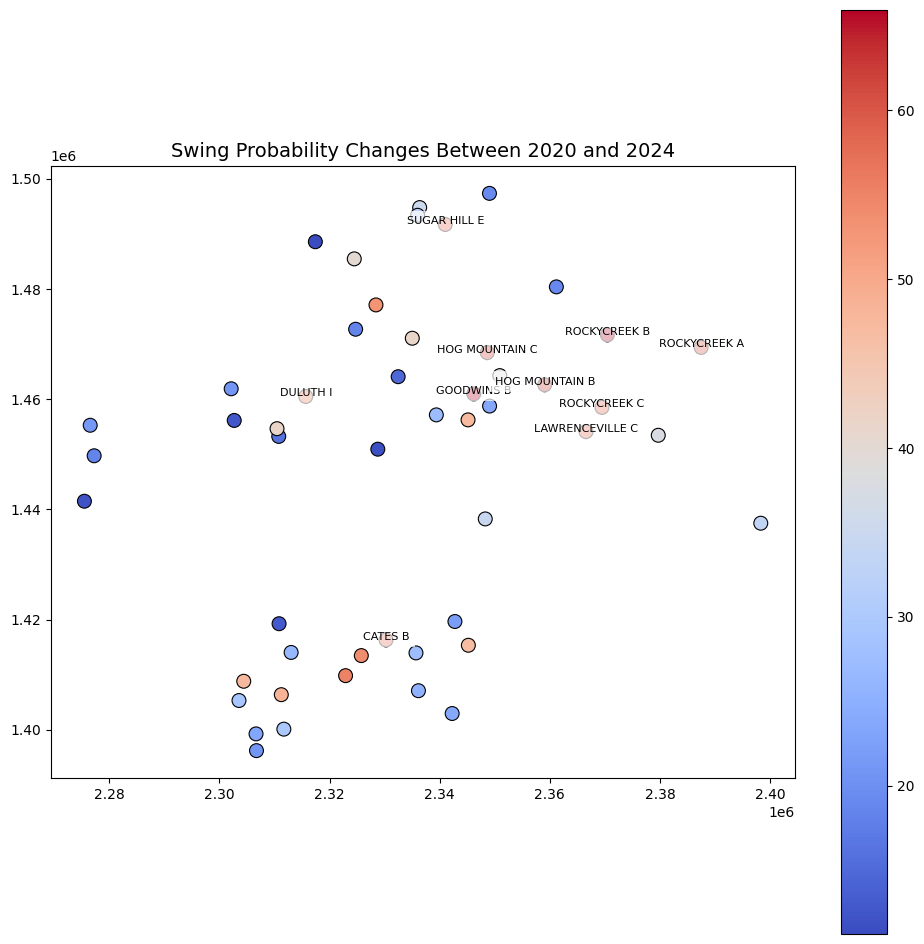

In [ ]:

# Path to your shapefile ZIP stored in Google Drive
shapefile_path = "/content/drive/MyDrive/CSVs/Administrative_-5726998422312426082.zip"

# Load the shapefile
gdf = gpd.read_file(shapefile_path)

# Swing probability data (with numbers removed)
swing_data = {
    "Precinct": [
        "Goodwins B", "Rockycreek B", "Hog Mountain B", "Hog Mountain C", "Rockycreek A",
        "Sugar Hill E", "Rockycreek C", "Lawrenceville C", "Cates B", "Duluth I",
        "Berkshire O", "Cates O", "Suwanee B", "Berkshire J", "Berkshire E",
        "Lawrenceville H", "Cates N", "Duluth G", "Suwanee F", "Suwanee E",
        "Hog Mountain D", "Harbins B", "Sugar Hill B", "Lawrenceville E", "Harbins C",
        "Sugar Hill F", "Garners A", "Berkshire Q", "Cates G", "Goodwins D",
        "Berkshire M", "Cates F", "Cates A", "Lawrenceville K", "Berkshire N",
        "Cates M", "Pinckneyville Z", "Duluth H", "Berkshire G", "Sugar Hill A",
        "Pucketts E", "Suwanee C", "Pinckneyville L", "Duluth B", "Goodwins H",
        "Berkshire F", "Duluth C", "Pinckneyville A1", "Goodwins E", "Suwanee D",
    ],
    "Swing Probability": [
        65.92, 65.10, 62.36, 61.59, 59.94, 58.22, 58.18, 57.81, 57.50, 55.26,
        55.22, 53.78, 52.93, 48.51, 47.49, 47.19, 46.73, 41.59, 41.57, 39.98,
        38.23, 37.63, 35.38, 34.46, 33.27, 31.76, 29.61, 29.17, 27.32, 27.20,
        26.59, 25.29, 23.89, 23.69, 23.32, 22.10, 21.22, 21.06, 20.91, 19.30,
        19.14, 18.44, 18.43, 16.10, 14.81, 12.98, 12.62, 12.30, 11.69, 11.24
    ]
}

# Convert to DataFrame
df = pd.DataFrame(swing_data)

# Ensure precinct names match between shapefile and dataset
df["Precinct"] = df["Precinct"].str.upper()  # Convert to uppercase for consistency
gdf["PRECINCT_N"] = gdf["PRECINCT_N"].str.upper()  # Convert shapefile column to uppercase

# Merge the shapefile with swing probability data
gdf = gdf.merge(df, left_on="PRECINCT_N", right_on="Precinct", how="left")

# Filter top precincts with highest swing probabilities (top 10 by default)
top_precincts = gdf.nlargest(10, "Swing Probability")

# Create plot
fig, ax = plt.subplots(figsize=(12, 12))
gdf.plot(column="Swing Probability", cmap="coolwarm", linewidth=0.8, edgecolor='black', legend=True, ax=ax, markersize=100)  # Increased marker size

# Add labels only to the highest swing probability precincts
for x, y, label in zip(top_precincts.geometry.centroid.x, top_precincts.geometry.centroid.y, top_precincts["Precinct"]):
    plt.text(x, y, label, fontsize=8, ha="center", color="black", bbox=dict(facecolor="white", alpha=0.7, edgecolor="none"))

# Set the title of the plot
ax.set_title("Swing Probability Changes Between 2020 and 2024", fontsize=14)

# Show the plot
plt.show()
